# Modificació A partir Sprint6 T6.1
Incorporo els comentaris de la Verònica al Sprint 6 T6.1:

    1. **RESOLT**.Duración: Mencionas que vas a imputar los valores extremos superiores a 2000. Te sugiero revisar el código, ya que parece que la transformación no se llevó a cabo correctamente.
 
    2. **RESOLT**.Análisis de Correlación: El análisis de correlación para detectar multicolinealidad se debe realizar principalmente en el conjunto de entrenamiento. Sin embargo, es válido hacer una revisión adicional en el conjunto de prueba después de entrenar el modelo.

    3. **RESOLT**.Estandarización de Variables Numéricas: Estás utilizando fit_transform en el conjunto de prueba, lo cual no es correcto. Al aplicar la estandarización, deberías utilizar transform en lugar de fit_transform, ya que el StandardScaler ya se ajustó en el conjunto de entrenamiento.

    4. **RESOLT**. Recategorización de la Variable "Job": La recategorización de la variable "job" me parece un tanto arbitraria, especialmente en la categoría "other". Te recomiendo que justifiques esta decisión en función del problema de negocio que estás abordando. 

    5. **NO RESOLT**. Manejo de Variables Categóricas con Muchas Categorías: Si las variables categóricas tienen muchas categorías, te sugiero utilizar label encoding en lugar de one-hot encoding para evitar un aumento innecesario de la dimensionalidad del conjunto de datos.

## Carregar les dades

In [893]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [894]:
csv_url = "https://raw.githubusercontent.com/ITACADEMYprojectes/projecteML/main/bank_dataset.CSV"
df = pd.read_csv(csv_url)

## Informació general, primeres files i sumari estadístic

In [896]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


,age,balance,day,duration,campaign,pdays,previous
count,11152.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.235384,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.914934,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Histogrames per les variables numèriques

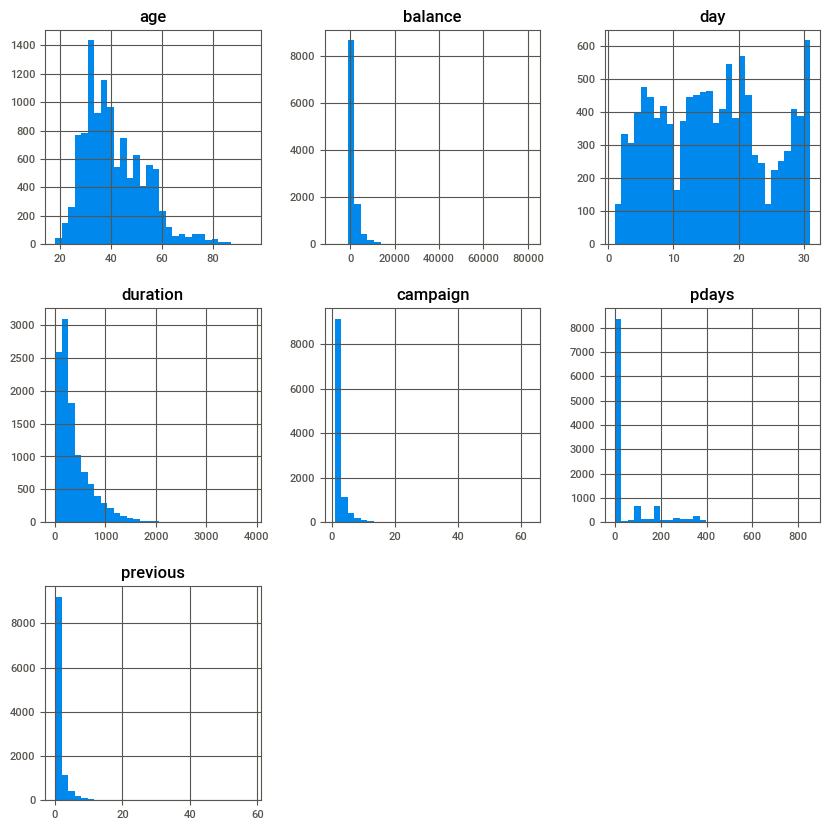

In [898]:
vars_con = [1,5,9,11,12,13,14]
vars_fac = [2,3,4,6,7,8,10,15,16]
df.hist(bins=30, figsize=(10, 10))
plt.show()

## Boxplot per detecció d'outliers univariants en les variables numèriques

No és gaire informatiu doncs les escales són molt diferents. 

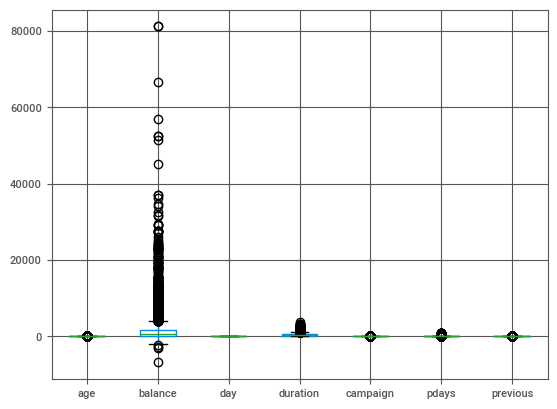

In [900]:
df.boxplot()
plt.show()

## Tractament d'outliers

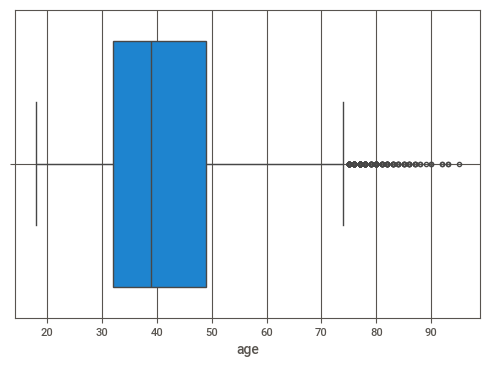

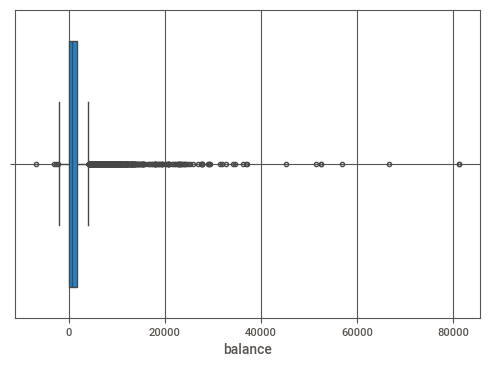

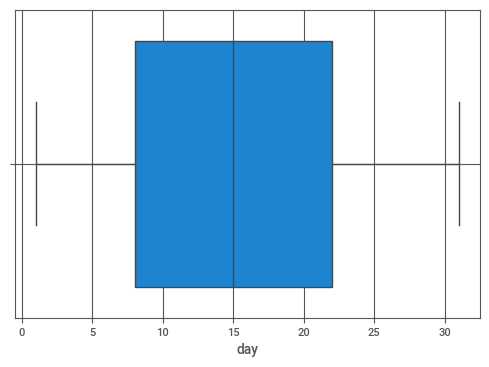

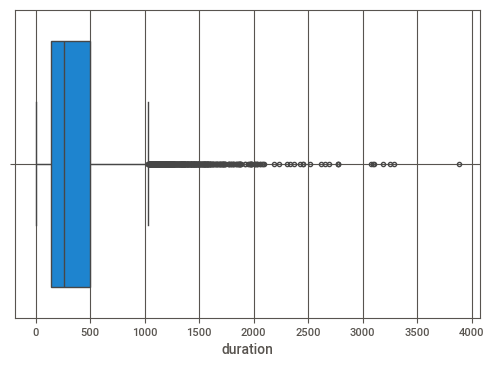

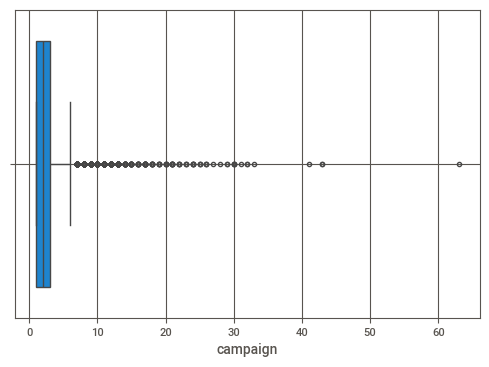

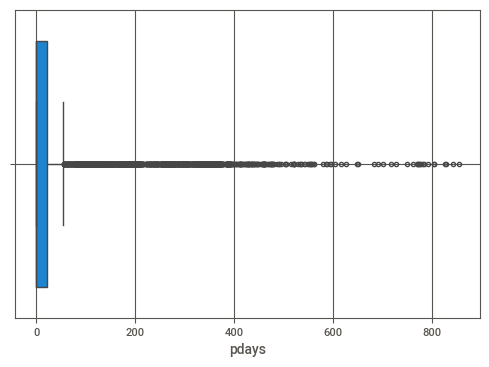

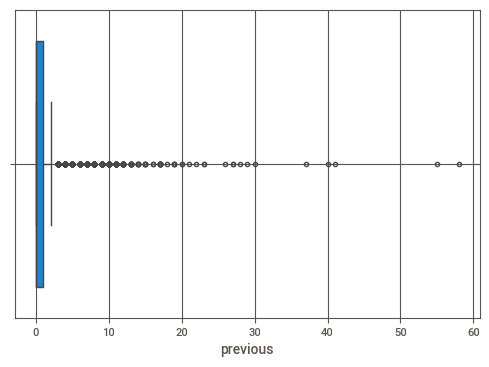

In [902]:
colsnum = df.select_dtypes(include=["number"]).columns.tolist()
for column in colsnum:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # No se detectan outliers

### Anàlisi una a una de les variables numèriques per detectar outliers
Després d'examinar el boxplot i calcular les fites superiors als outliers suaus i severs decideixo no intervenir: els outliers d'age són correctes, raonables i no cal intervenció en aquest punt, potser desestimar les persones més grans de 80 anys en la modelització (dificultats de comprensió dels productes finances, jo crec que majorment no n'estan interessats).

32.0
49.0
IQR 17.0
Llindar superior outliers suaus 74.5
Llindar superior outliers severs 100.0


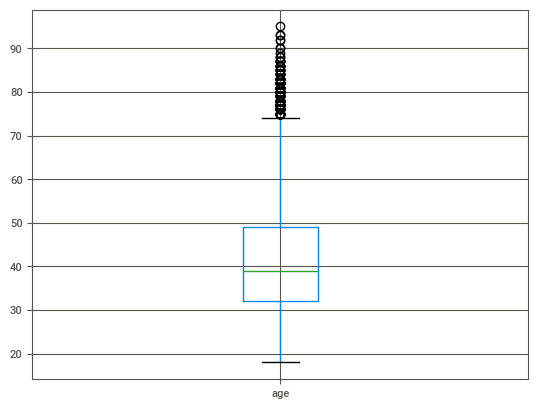

In [904]:
p = df.boxplot(column=['age'], return_type='axes')
p.plot()
print( df['age'].quantile(0.25))
print( df['age'].quantile(0.75)) 

# 50% de la població està entre 32 i 49
# Llindars per outliers suaus
# print(np.min(edat), np.quantile(edat, 0.25), np.median(edat), np.quantile(edat, 0.75), np.max(edat))
iqr = df['age'].quantile(0.75)-df['age'].quantile(0.25)
print("IQR",iqr)
upthr = df['age'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
print("Llindar superior outliers severs",df['age'].quantile(0.75)+3*iqr)
# Per ara no cal tractar els outliers d'age

#### Balance
Distribució extrema, tipus Pareto, per tant els outliers són consustancials, però a partir de 40000 caldria suprimir les observacions 
o millor imputar-les a la mediana. Quines són?. Hi ha outliers severs inferiors que tractaré imputant a -4636 (llindar d'outlier sever inferior). Per tant, és com aplicar una Winzorització a mida.


Llindar superior outliers suaus 4087.0
Llindar superior outliers severs 6466.0
Llindar inferior outliers severs -4636.0


-6847

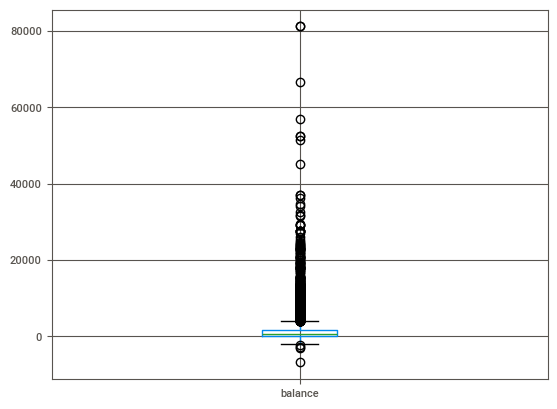

In [906]:
p = df.boxplot(column=['balance'], return_type='axes')
p.plot()
# 50% de la població està entre 32 i 49
# Llindars per outliers suaus
iqr = df['balance'].quantile(0.75)-df['balance'].quantile(0.25)
iqr
upthr = df['balance'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df['balance'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
lothr = df['balance'].quantile(0.25)-3*iqr
print("Llindar inferior outliers severs",lothr)
df['balance'].min()

[]

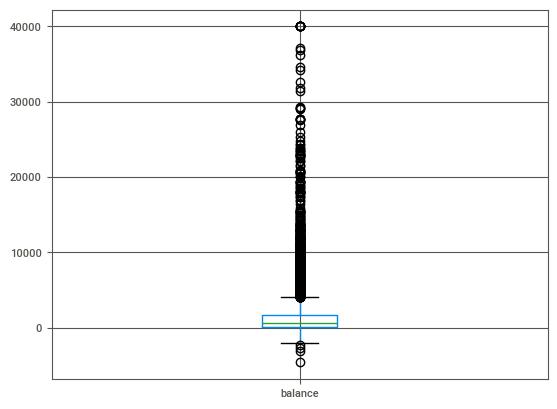

In [907]:
cols = ['balance']
df.loc[df['balance'] > 40000, cols] = 40000
df.loc[df['balance'] < -4636, cols] = -4636
# print( df.isnull().sum())
#df['balance'] = df['balance'].fillna(df['balance'].median())
p = df.boxplot(column=['balance'], return_type='axes')
p.plot()

#### Day
Cap problema com era d'esperar a day

Llindar superior outliers suaus 43.0
Llindar superior outliers severs 64.0


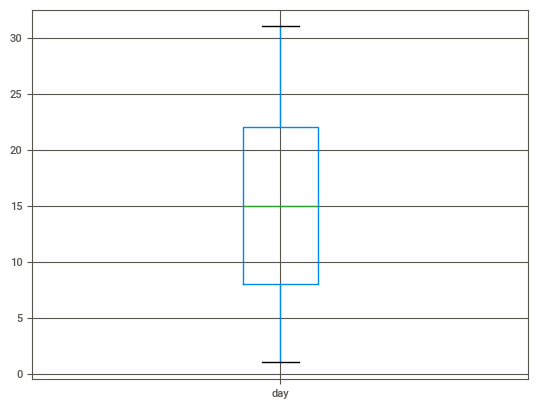

In [909]:
p = df.boxplot(column=['day'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df['day'].quantile(0.75)-df['day'].quantile(0.25)
iqr
upthr = df['day'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df['day'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
# 

#### Duration
Torna a tenir una caiguda exponencial, però hi ha molts zeros, per ara imputo els outliers extrems superiors a 2000

Llindar superior outliers suaus 1033.0
Llindar superior outliers severs 1570.0


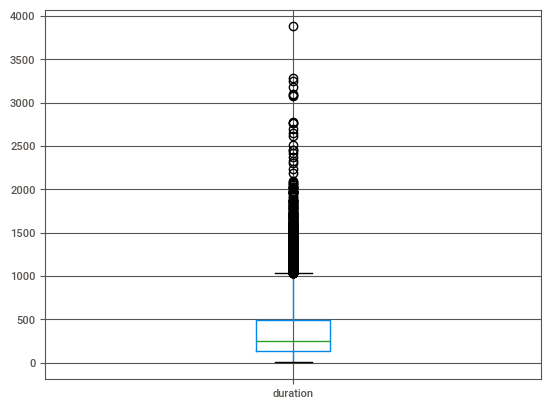

In [911]:
p = df.boxplot(column=['duration'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df['duration'].quantile(0.75)-df['duration'].quantile(0.25)
iqr
upthr = df['duration'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df['duration'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)

[]

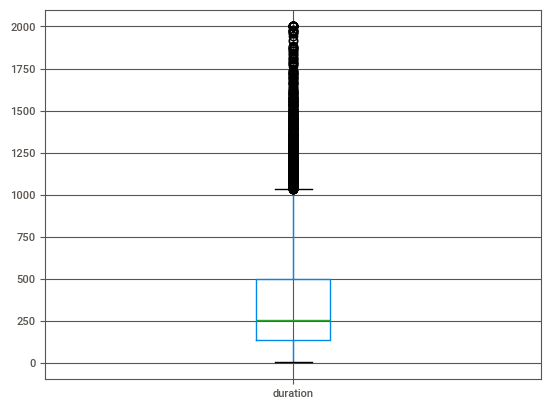

In [912]:
cols = ['duration']
df.loc[df['duration'] > 2000, cols] = 2000

p = df.boxplot(column=['duration'], return_type='axes')
p.plot()

# Resolt comentari 1 del feedback T6.1

#### Previous
Torna a tenir una caiguda exponencial, però hi ha molts zeros, els outliers extrems superiors els imputo a 30

Llindar superior outliers suaus 8.5
Llindar superior outliers severs 13.0


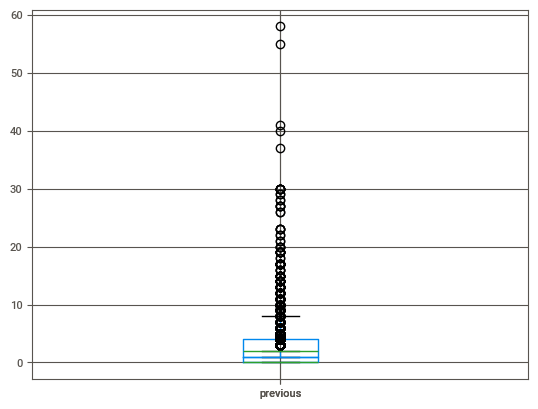

In [914]:
#p = df.boxplot(column=['previous'], return_type='axes')
#p.plot()
cols = ['previous']
df1 = df.loc[df['previous'] >0, cols]
p = df1.boxplot(column=['previous'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df1['previous'].quantile(0.75)-df1['previous'].quantile(0.25)
iqr
upthr = df1['previous'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df1['previous'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
df.loc[df['previous'] > 30, cols] = 30
p = df.boxplot(column=['previous'], return_type='axes')
# Torna a tenir una cua superior, per ara no pup.plot()c prendre una decisió de qué fer

#### Pdays
*Number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)*

Torna a tenir una caiguda exponencial, però hi ha molts -1 dels qui no han participat en campanyes anteriors, per ara filtro les observacions dels qui han participat en alguna campanya anterior i els outliers extrems superiors els deixo com estan, per ara.

Llindar superior outliers suaus 568.0
Llindar superior outliers severs 850.0


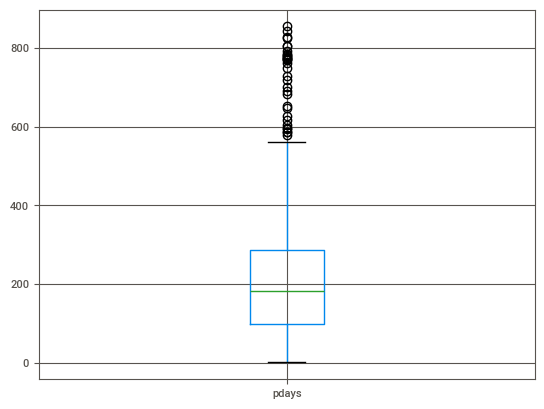

In [916]:
# Delicat, hi ha observacions -1
cols = ['pdays']
df1 = df.loc[df['pdays'] >-1, cols]
p = df1.boxplot(column=['pdays'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df1['pdays'].quantile(0.75)-df1['pdays'].quantile(0.25)
iqr
upthr = df1['pdays'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df1['pdays'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
# No cal fer res

# Campaign
*Number of contacts performed during this campaign and for this client (numeric, includes last contact)*

Torna a tenir una caiguda exponencial, però hi ha molts 0 dels qui no han estat localitzats a la campanya, per ara filtro les observacions dels qui no han participat en la campanya actual i els outliers extrems superiors (superiors a 10) d'aquest subconjunt els imputo a 10 (és a dir, semblant a una winzorització).

Llindar superior outliers suaus 6.0
Llindar superior outliers severs 9.0


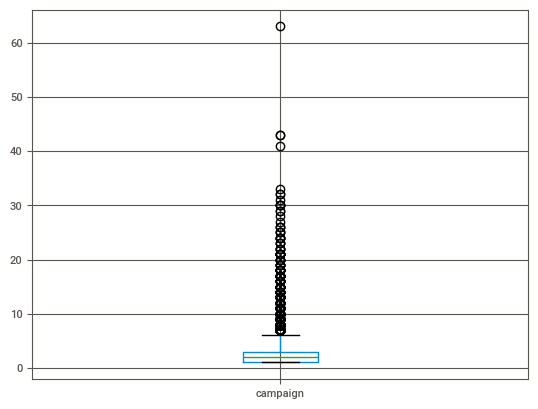

In [918]:
# Delicat, hi ha observacions 0
cols = ['campaign']
df1 = df.loc[df['campaign'] >0, cols]
p = df1.boxplot(column=['campaign'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df1['campaign'].quantile(0.75)-df1['campaign'].quantile(0.25)
iqr
upthr = df1['campaign'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df1['campaign'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
# No cal fer res

[]

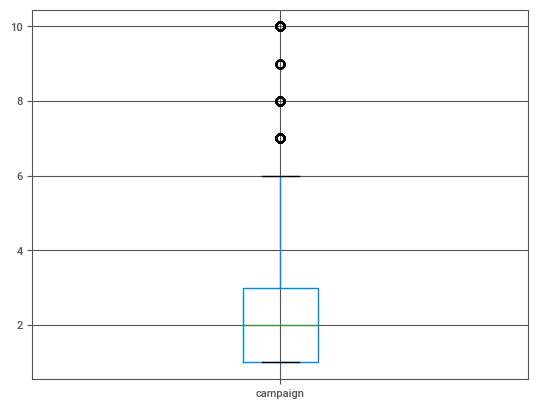

In [919]:
cols = ['campaign']
df.loc[df['campaign'] > 10, cols] = 10
p = df.boxplot(column=['campaign'], return_type='axes')
p.plot()

## Comptar les categories dels factors

Massa categories en el factor job, caldrà reagrupar-les molt possiblement. Per altra banda, tots els factors amb nivell unknown i poques observacions 'unknown' cal resseguir-les, donarà problemes en la modelització (regressió logística).

**Cal remarcar que el target diposit està balancejat (Yes/No)**

In [921]:
for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64
marital
married     6349
single      3517
divorced    1291
Name: count, dtype: int64
education
secondary    5474
tertiary     3685
primary      1500
unknown       496
Name: count, dtype: int64
default
no     10994
yes      168
Name: count, dtype: int64
housing
no     5881
yes    5281
Name: count, dtype: int64
loan
no     9702
yes    1460
Name: count, dtype: int64
contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64
month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64
poutcome
unknown    8326
failure    1228
success    1071
other       537
Nam

## Visualització valors nuls
No es veu res, per tant millor comptar-los

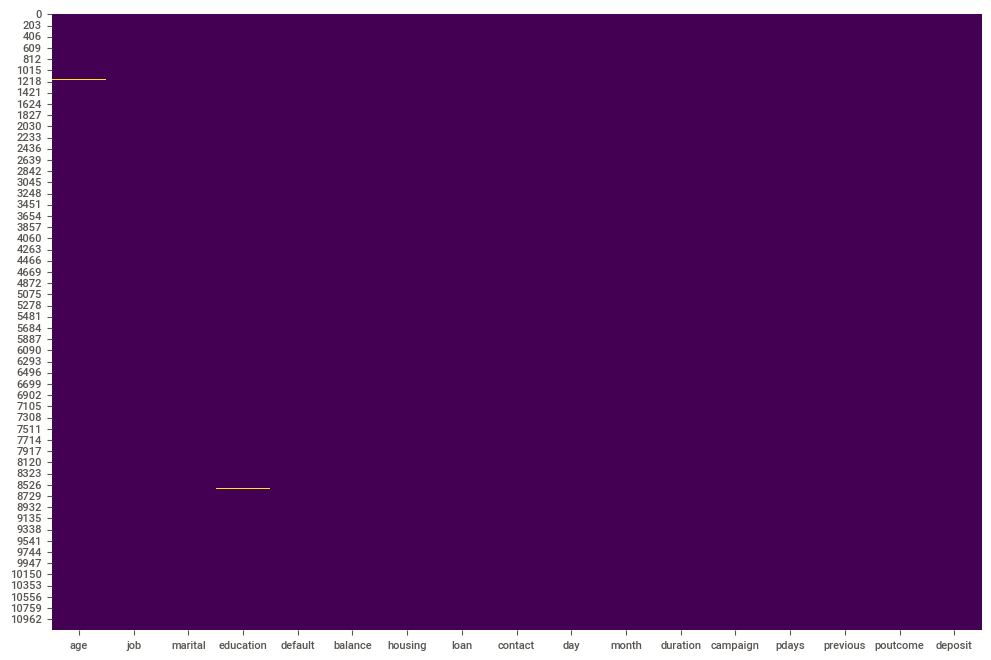

age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [923]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()
df.isnull().sum()

## Dades faltants
    -Marital té 3 categories i 5 missings, per tant caldria una categoria "unknown". 
    -Education té 10 missings i ja té definida la categoria "unknown", per tant cal assignar aquesta categoria.
    -Age té 10 missings, es podria fer una imputació amb la mediana doncs no sé com fer imputacions més intel.ligents amb Python.

In [925]:
df['age'] = df['age'].fillna(df['age'].median())
df['education'] = df['education'].fillna('unknown')
df['marital'] = df['marital'].fillna('unknown')
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

# Anàlisi Exploratòria univariant automatitzada amb Sweetviz

**Impresionant**

In [927]:
import sweetviz as sv
report = sv.analyze(df)
report.show_html('EDA_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


En aquest punt m'interessa perfilar la relació de les variables numèriques amb el target deposit, ara bé, això està fet al report pels factors (basat en el que diuen un index d'incertesa, m'hauria agradat més veure un pvalor del test chi quadrat entre deposit i cadascun dels factors):

    -poutcome 0.07
    -month 0.07
    -contact 0.05
    -housing 0.03
    -job 0.02
    -loan 0.01
    -education 0.01
    -marital 0.01
    -default 0.00

I per les numèriques es pot extreure també una associació (en diu correlació, incorrecte el terme, m'agradaria veure el pvalor d'un test no paramètric tipus Kruskal-Wallis amb variable continua segons factor dipòsit o un Wilcoxon doncs té dos nivells el target que en Python és Mann-Whitney U rank test per 2 mostres independents).

    -duration 0.45
    -pdays 0.15
    -previous 0.14
    -campaign 0.13
    -balance 0.08
    -day 0.06 (aquesta variable no té sentit usar-la directament)
    -age 0.04



## Associació bivariant entre target deposit i numèriques
### pdays

MannwhitneyuResult(statistic=array([18454802.]), pvalue=array([6.23493583e-112]))


<Axes: xlabel='deposit', ylabel='pdays'>

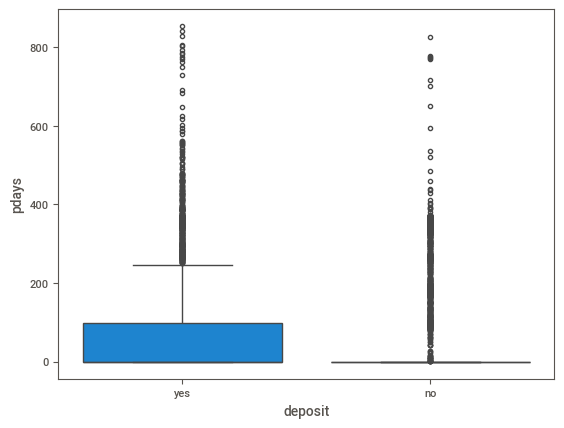

In [930]:
# Defining data groups
from scipy import stats
cols = ['pdays']
df1 = df.loc[df['deposit'] =='yes', cols]
df2 = df.loc[df['deposit'] =='no', cols] 
# Conduct the Mann-Whitney U Test 
result = stats.mannwhitneyu(df1, df2)
# Print the result
print(result)
# Vull visualitzar els boxplots de pdays a cada categoria de deposit

# create grouped boxplot  
sns.boxplot(x = df['deposit'], 
            y = df['pdays'], 
            hue = df['deposit'])


### previous

Clarament vec ara que cal tractar els outliers severs que havia detectat (per sobre de 50 trucades)

MannwhitneyuResult(statistic=array([18687528.]), pvalue=array([2.5996891e-130]))


<Axes: xlabel='deposit', ylabel='previous'>

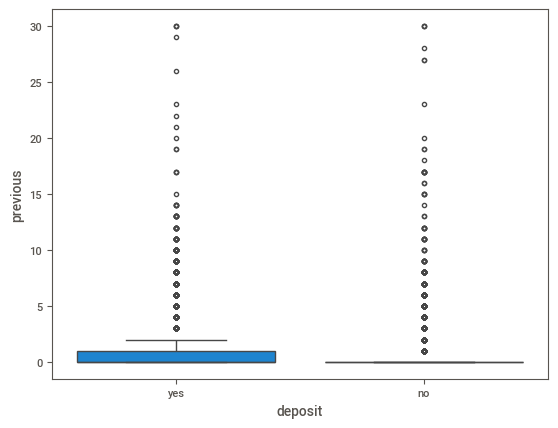

In [932]:
# Defining data groups
from scipy import stats
cols = ['previous']
df1 = df.loc[df['deposit'] =='yes', cols]
df2 = df.loc[df['deposit'] =='no', cols] 
# Conduct the Mann-Whitney U Test 
result = stats.mannwhitneyu(df1, df2)
# Print the result
print(result)
# Vull visualitzar els boxplots de previous a cada categoria de deposit
# create grouped boxplot  
sns.boxplot(x = df['deposit'], 
            y = df['previous'], 
            hue = df['deposit'])


## Associació bivariant entre target deposit i factors
### poutcome

deposit     no   yes
poutcome            
failure    610   618
other      230   307
success     93   978
unknown   4940  3386
deposit         no       yes
poutcome                    
failure   0.496743  0.503257
other     0.428305  0.571695
success   0.086835  0.913165
unknown   0.593322  0.406678
deposit         no       yes
poutcome                    
failure   0.103865  0.116846
other     0.039162  0.058045
success   0.015835  0.184912
unknown   0.841137  0.640197
The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are: 1004.635780185333 3 1.7761850102620281e-217


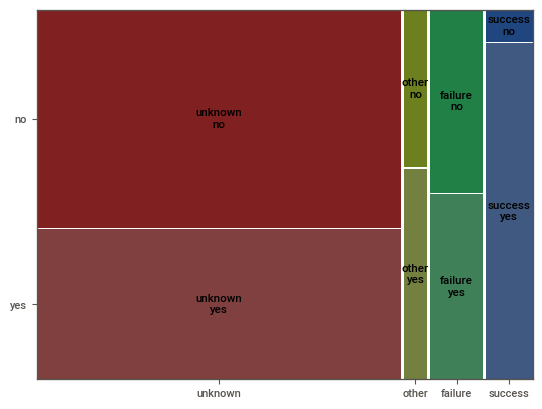

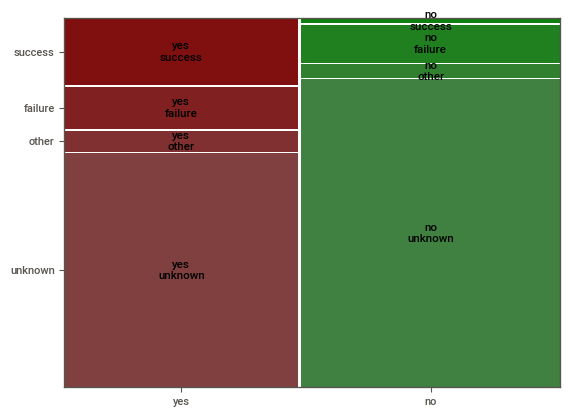

In [934]:
CrosstabResult = pd.crosstab(index=df['poutcome'], columns=df['deposit'])
print(CrosstabResult)
CrosstabRows = pd.crosstab(index=df['poutcome'], columns=df['deposit'], normalize="index")
print(CrosstabRows)
CrosstabCols = pd.crosstab(index=df['poutcome'], columns=df['deposit'], normalize="columns")
print(CrosstabCols)

# Mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['poutcome', 'deposit'])
mosaic(df, [ 'deposit', 'poutcome'])
# importing the required function
from scipy.stats import chi2_contingency
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are:', ChiSqResult[0], ChiSqResult[2], ChiSqResult[1])

Clarament els qui van contractar en una campanya anterior un dipòsit, tenen una probabilitat per sobre el 90% de contractar-ne un altre a la campanya actual, tantmateix si no van contractar-lo no afecta a la situació actual, però si són nous en les campanyes, aleshores és una mica inferior la probabilitat de contractar.

# Conclusions EDA

Després de l'EDA univariant and bivariant (perfilar target) es té una comprensió més fina de les característiques del dataset. 

# Preparació de les mostres de treball i de test (Tasca 6.1). Estratificació segons el target

In [939]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Dividir el dataset en conjunts de treball i test 75-25 Estratificat pel target diposit
train, test = train_test_split(df, test_size=0.25, random_state=28061963, stratify=df['deposit'])
tr = train.groupby('deposit').count()
tst = test.groupby('deposit').count()
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
print("Tamany del conjunt de treball (train):", train.shape)
print("Tamany del conjunt de test (test):", test.shape)
# compare the dataset amb Sweetviz
compare = sv.compare(source=train, compare=test, target_feat="deposit")
# Show the result
compare.show_html('Compare.html')

Tamany del conjunt de treball (train): (8371, 17)
Tamany del conjunt de test (test): (2791, 17)


                                             |          | [  0%]   00:00 -> (? left)

Report Compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Correlació entre numèriques a la mostra test per prevenir la multicolinearitat

La correlació més elevada és de 0.54 entre previous i pdays a la working sample (0.49 a la test sample). La correlació entre la resta de parelles de variables és desestimable.

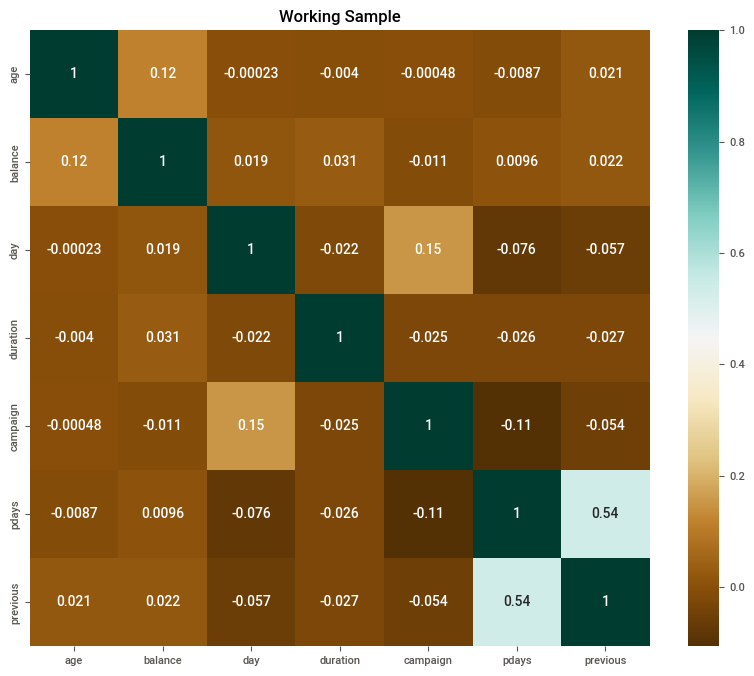

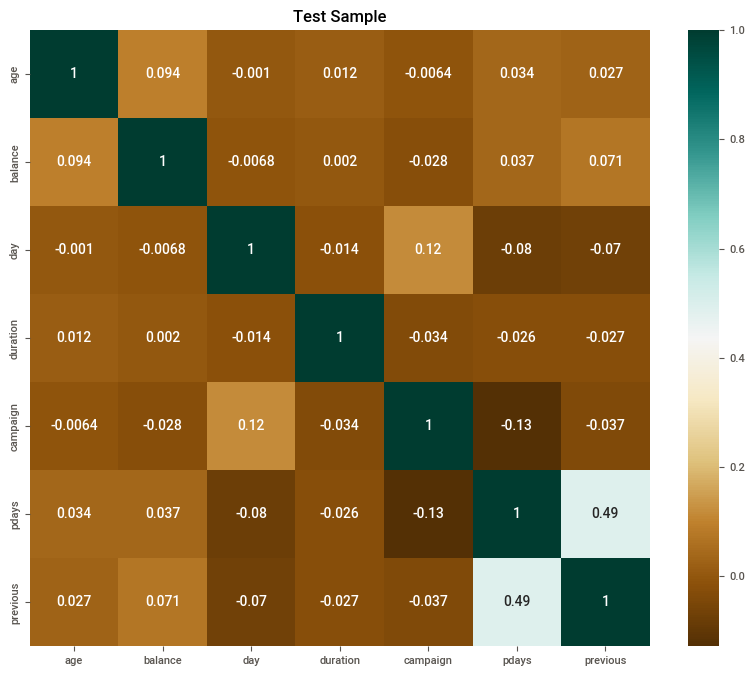

In [941]:
# Filtrar les columnes numèriques de la mostra de treball
train_numeric = train.select_dtypes(include=['number'])
train_factor = train.select_dtypes(include=['object'])
# Correlació entre les variables numèriques de la working sample
wcorr_matrix = train_numeric.corr()
# Pintar el heatmap amb les correlacions entre numèriques de la mostra de treball
plt.figure(figsize=(10, 8))
sns.heatmap(wcorr_matrix, annot=True, cmap='BrBG').set_title('Working Sample')
plt.show()

# Correlació entre les variables numèriques de la test sample
test_numeric = test.select_dtypes(include=['number'])
test_factor = test.select_dtypes(include=['object'])
tcorr_matrix = test_numeric.corr()
# Pintar el heatmap amb les correlacions entre numèriques de la mostra de treball
plt.figure(figsize=(10, 8))
sns.heatmap(tcorr_matrix, annot=True, cmap='BrBG').set_title('Test Sample')
plt.show()
# La correlació més elevada és de 0.52 entre previous i pdays. La correlació entre la resta de parelles de variables és desestimable.

## Estandardització
**Ho evitaré el màxim de temps que pugui doncs perdo la possibilitat de fer una interpretació directa del estimadors del model de regressió logística** que aplicaré. Sé que no és el que suggereix el curs, però personalment ho evito; més tard puc repetir l'exercici amb estandardització. Guardo les variables numèriques originals, més les escalades en el mateix dataframe (train, test)

In [943]:
# Especificar las columnas numéricas a estandarizar al working set. Day no té sentit. Pdays, campaign i previous tenen un munt de zeros
train_num_scaled = train_numeric
colsnum = train_num_scaled.select_dtypes(include=["number"]).columns.tolist()
print("Llista de columnes numèriques:", colsnum)
cols2Stand = ['age', 'balance','duration']
sccols2Stand = ['scage', 'scbalance','scduration']
scaler = StandardScaler() # Inicialitzar l'escalat standard
train_num_scaled[sccols2Stand] = scaler.fit_transform(train_num_scaled[cols2Stand])
train_num_scaled.describe()
print("Train Scaled", train_num_scaled.shape)
train_scaled = pd.concat([train_num_scaled,train_factor], axis=1)
print("Train Scaled", train_scaled.shape)
train_scaled.to_csv('escalat_train.csv', index=False)
train_scaled.isnull().sum()

Llista de columnes numèriques: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Train Scaled (8371, 10)
Train Scaled (8371, 20)


age           0
balance       0
day           0
duration      0
campaign      0
pdays         0
previous      0
scage         0
scbalance     0
scduration    0
job           0
marital       0
education     0
default       0
housing       0
loan          0
contact       0
month         0
poutcome      0
deposit       0
dtype: int64

In [944]:
# Especificar las columnas numéricas a estandarizar al test set. Day no té sentit. Pdays, campaign i previous tenen un munt de zeros
test_num_scaled = test_numeric

test_num_scaled[sccols2Stand] = scaler.transform(test_num_scaled[cols2Stand]) # Comentari 3 Verònica
test_scaled = pd.concat([test_num_scaled,test_factor], axis=1)
test_scaled.to_csv('escalat_test.csv', index=False)
test_scaled.describe()
test_scaled.isnull().sum()

age           0
balance       0
day           0
duration      0
campaign      0
pdays         0
previous      0
scage         0
scbalance     0
scduration    0
job           0
marital       0
education     0
default       0
housing       0
loan          0
contact       0
month         0
poutcome      0
deposit       0
dtype: int64

               age       balance          day     duration     campaign  \
count  8371.000000   8371.000000  8371.000000  8371.000000  8371.000000   
mean     41.226257   1540.724406    15.689284   374.334130     2.401864   
std      11.890377   3020.023675     8.435551   342.339769     1.996416   
min      18.000000  -4636.000000     1.000000     2.000000     1.000000   
25%      32.000000    123.000000     8.000000   138.500000     1.000000   
50%      39.000000    550.000000    15.000000   256.000000     2.000000   
75%      49.000000   1745.000000    22.000000   504.000000     3.000000   
max      95.000000  40000.000000    31.000000  2000.000000    10.000000   

             pdays     previous         scage     scbalance    scduration  
count  8371.000000  8371.000000  8.371000e+03  8.371000e+03  8.371000e+03  
mean     50.071318     0.797276  4.838243e-17 -4.159192e-17 -7.066382e-17  
std     107.059608     2.083186  1.000060e+00  1.000060e+00  1.000060e+00  
min      -1.000000  

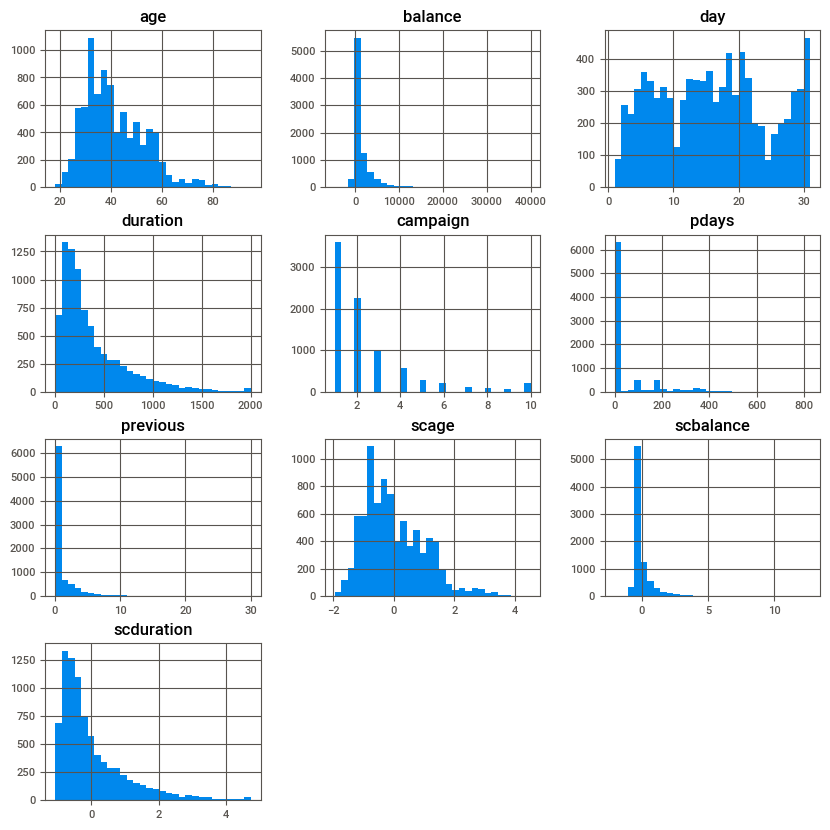

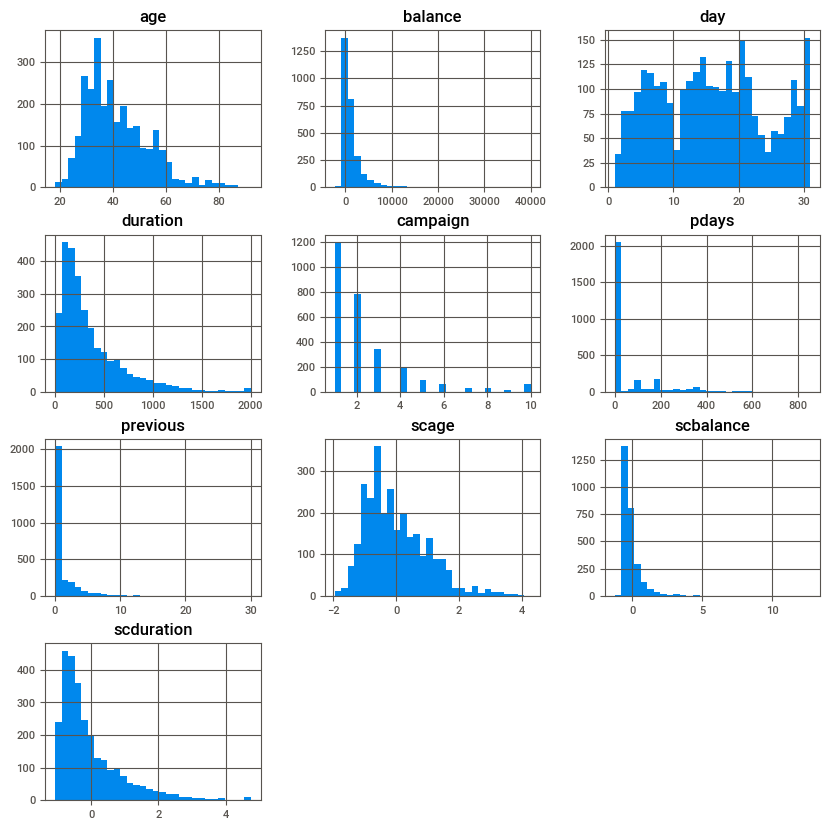

In [945]:
# Histogram of numeric variables
colsnum = train_num_scaled.select_dtypes(include=["number"]).columns.tolist()
print( train_scaled.describe() )# Com fer-ho visible?
print("Train Scaled", train_scaled.shape)

# Definir les columnes a visualitzar
train_num_scaled.hist(bins=30, figsize=(10, 10))
plt.show()

test_num_scaled.hist(bins=30, figsize=(10, 10))
plt.show()

## Label Encoding vs. One-Hot Encoding

**Reducció del nombre de categories de les variables qualitatives (factors)**

Hi ha variables com job amb moltes categories, algunes amb poques observacions, busco agrupar categories segons la seva relació amb el target. Concretament redueixo les categories de job, marital (hi ha 1 unknown, que el poso a married), poutcome (unknown van a failure) i month, defining gjob (3), gmarital (3), gpoutcome (3) i gmonth (2).

L'agrupació de job es fa en funció del tipus de feina

job
management       1923
blue-collar      1503
technician       1347
admin.            963
services          690
retired           594
self-employed     302
unemployed        275
student           270
entrepreneur      245
housemaid         210
unknown            49
Name: count, dtype: int64
marital
married     4814
single      2589
divorced     964
unknown        4
Name: count, dtype: int64
education
secondary    4107
tertiary     2757
primary      1136
unknown       371
Name: count, dtype: int64
default
no     8239
yes     132
Name: count, dtype: int64
housing
no     4398
yes    3973
Name: count, dtype: int64
loan
no     7296
yes    1075
Name: count, dtype: int64
contact
cellular     6005
unknown      1777
telephone     589
Name: count, dtype: int64
month
may    2144
jul    1121
aug    1103
jun     914
apr     720
nov     715
feb     586
oct     284
jan     257
sep     238
mar     208
dec      81
Name: count, dtype: int64
poutcome
unknown    6287
failure     904
success     788
othe

age           0
balance       0
day           0
duration      0
campaign      0
pdays         0
previous      0
scage         0
scbalance     0
scduration    0
job           0
marital       0
education     0
default       0
housing       0
loan          0
contact       0
month         0
poutcome      0
deposit       0
gjob          0
gpoutcome     0
gmonth        0
gmarital      0
dtype: int64

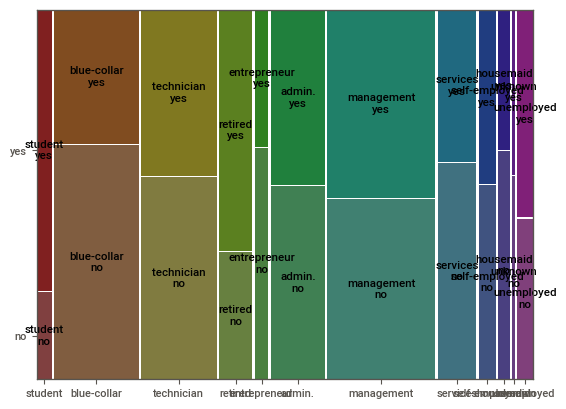

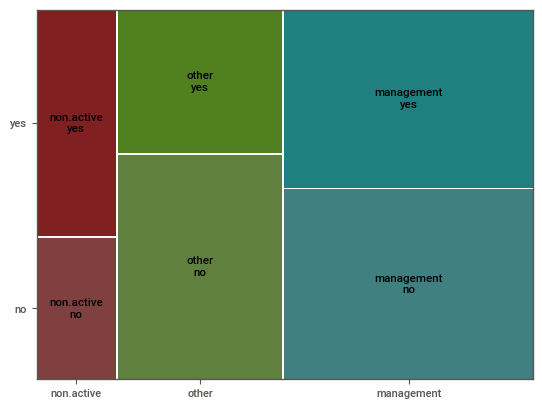

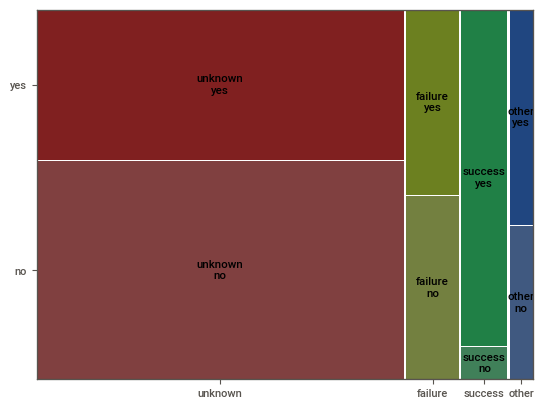

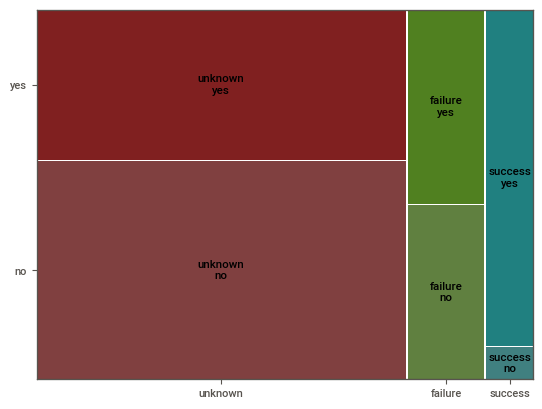

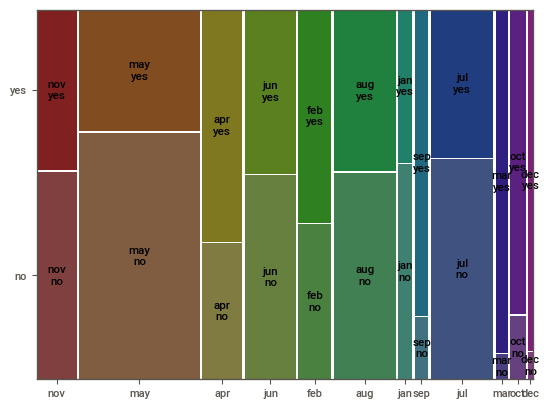

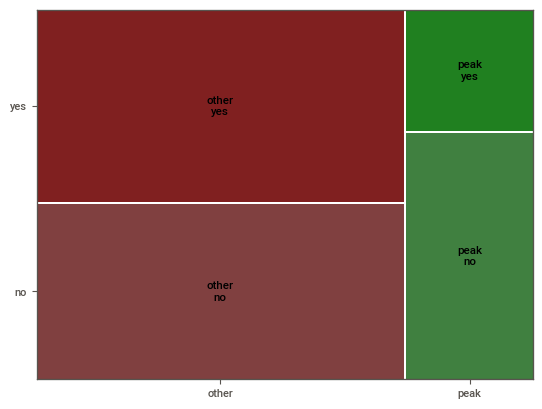

In [947]:
for column in train_scaled.select_dtypes(include=['object']).columns:
    print(train_scaled[column].value_counts())
from statsmodels.graphics.mosaicplot import mosaic
mosaic(train, ['job', 'deposit'])
# Definir la qualitativa gjob 
train_scaled['gjob'] = ''
train_scaled.gjob =  np.where( train_scaled['job'].isin(["management","technician","admin.","enterpreneur","self-employer"]),    "management",    train_scaled.gjob ) 
train_scaled.gjob =  np.where( train_scaled['job'].isin(["student","retired","unemployed","housemaid"]),    "non.active",  train_scaled.gjob )
train_scaled.gjob =  np.where( train_scaled['job'].isin(["blue-collar","services"]), "other",   train_scaled.gjob )
train_scaled.gjob =  np.where( train_scaled['gjob'].isin(["","unknown"]), "other",   train_scaled.gjob )

for column in train_scaled.select_dtypes(include=['object']).columns:
    print(train_scaled[column].value_counts())
mosaic(train_scaled, ['gjob', 'deposit'])

# poutcome
mosaic(train_scaled, ['poutcome', 'deposit'])
train_scaled['gpoutcome'] = train_scaled['poutcome']
train_scaled.gpoutcome =  np.where( train_scaled['poutcome'].isin(["other"]),    "failure",    train_scaled.gpoutcome ) 
mosaic(train_scaled, ['gpoutcome', 'deposit'])

# month
mosaic(train_scaled, ['month', 'deposit'])
train_scaled['gmonth'] = ''
train_scaled.gmonth =  np.where( train_scaled['month'].isin(["may","june","july","august"]),    "peak",    train_scaled.gmonth ) 
train_scaled.gmonth =  np.where( train_scaled['gmonth'].isin([""]), "other",   train_scaled.gmonth )
mosaic(train_scaled, ['gmonth', 'deposit'])

# marital
train_scaled['gmarital'] = train_scaled['marital']
train_scaled.gmarital =  np.where( train_scaled['gmarital'].isin(["unknown"]), "married",   train_scaled.gmarital )
print("Train Scaled", train_scaled.shape)
train_scaled.to_csv('train_scaledplus.csv', index=False)
train_scaled.isnull().sum()

## Reducció de la dimensionalitat en numèriques no és necessària pel limitat nombre de numèriques

## Aplicar la definició de noves categòriques a la mostra test

job
management       643
technician       476
blue-collar      441
admin.           371
services         233
retired          184
self-employed    103
student           90
entrepreneur      83
unemployed        82
housemaid         64
unknown           21
Name: count, dtype: int64
marital
married     1535
single       928
divorced     327
unknown        1
Name: count, dtype: int64
education
secondary    1367
tertiary      928
primary       364
unknown       132
Name: count, dtype: int64
default
no     2755
yes      36
Name: count, dtype: int64
housing
no     1483
yes    1308
Name: count, dtype: int64
loan
no     2406
yes     385
Name: count, dtype: int64
contact
cellular     2037
unknown       569
telephone     185
Name: count, dtype: int64
month
may    680
aug    416
jul    393
jun    308
nov    228
apr    203
feb    190
oct    108
jan     87
sep     81
mar     68
dec     29
Name: count, dtype: int64
poutcome
unknown    2039
failure     324
success     283
other       145
Name: count,

age           0
balance       0
day           0
duration      0
campaign      0
pdays         0
previous      0
scage         0
scbalance     0
scduration    0
job           0
marital       0
education     0
default       0
housing       0
loan          0
contact       0
month         0
poutcome      0
deposit       0
gjob          0
gpoutcome     0
gmonth        0
gmarital      0
dtype: int64

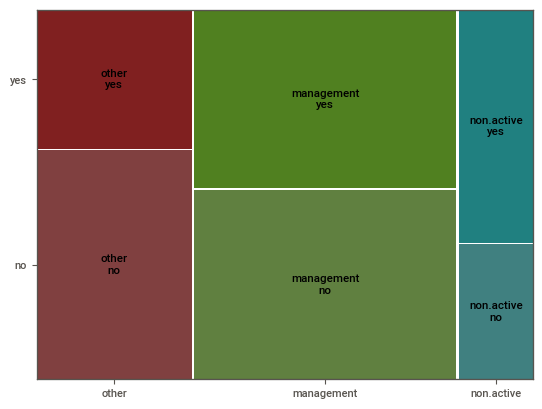

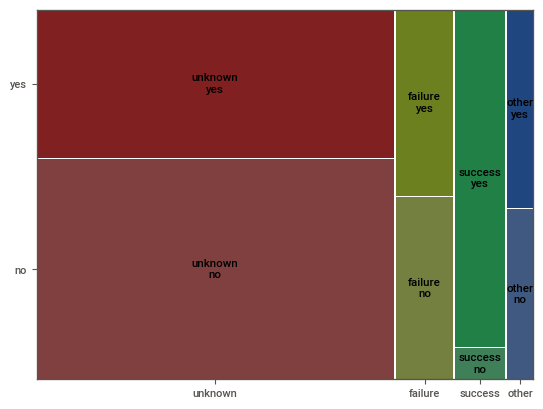

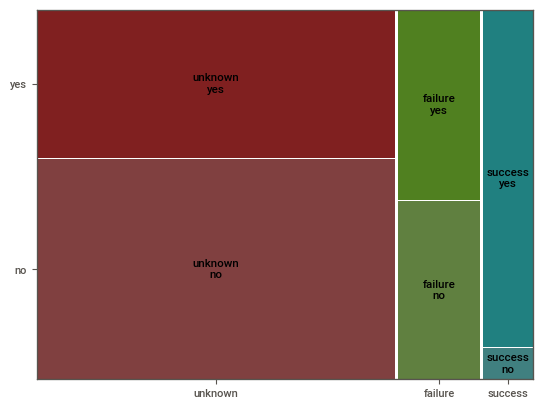

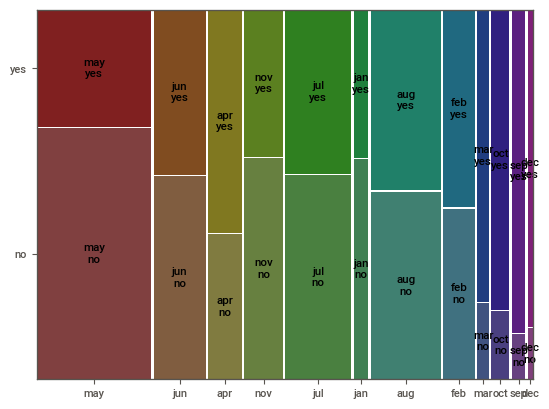

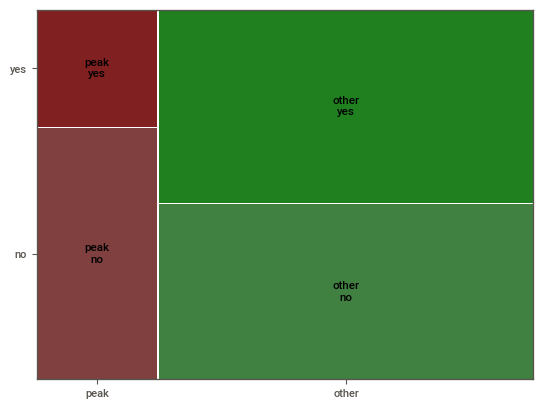

In [950]:
# Definir la qualitativa gjob agrupa management + technician + admin.+unknown = management  student+retired+unemployed=non.active 
# la resta = other
# Definir la qualitativa gjob 
test_scaled['gjob'] = ''
test_scaled.gjob =  np.where( test_scaled['job'].isin(["management","technician","admin.","enterpreneur","self-employer"]),    "management",    test_scaled.gjob ) 
test_scaled.gjob =  np.where( test_scaled['job'].isin(["student","retired","unemployed","housemaid"]),    "non.active",  test_scaled.gjob )
test_scaled.gjob =  np.where( test_scaled['job'].isin(["blue-collar","services"]), "other",   test_scaled.gjob )
test_scaled.gjob =  np.where( test_scaled['gjob'].isin(["","unknown"]), "other",   test_scaled.gjob )

for column in test_scaled.select_dtypes(include=['object']).columns:
    print(test_scaled[column].value_counts())
mosaic(test_scaled, ['gjob', 'deposit'])

# poutcome
mosaic(test_scaled, ['poutcome', 'deposit'])
test_scaled['gpoutcome'] = test_scaled['poutcome']
test_scaled.gpoutcome =  np.where( test_scaled['poutcome'].isin(["other"]),    "failure",    test_scaled.gpoutcome ) 
mosaic(test_scaled, ['gpoutcome', 'deposit'])

# month
mosaic(test_scaled, ['month', 'deposit'])
test_scaled['gmonth'] = ''
test_scaled.gmonth =  np.where( test_scaled['month'].isin(["may","june","july","august"]),    "peak",    test_scaled.gmonth ) 
test_scaled.gmonth =  np.where( test_scaled['gmonth'].isin([""]), "other",   test_scaled.gmonth )
mosaic(test_scaled, ['gmonth', 'deposit'])

# marital
test_scaled['gmarital'] = test_scaled['marital']
test_scaled.gmarital =  np.where( test_scaled['gmarital'].isin(["unknown"]), "married",   test_scaled.gmarital )

test_scaled.to_csv('test_scaledplus.csv', index=False)
test_scaled.isnull().sum()

## One-Hot encoding

Considero les variables contact, loan, housing, education, gjob, gmarital, gmonth i gpoutcome. Ha d'haver-hi una manera intel.ligent de fer-ho que no sigui per enumeració ... per em patina el Python. **No aconsegueixo crear les dummies i afegir-les al dataset escalat sense NAs**.

### Train

In [953]:
# creating one hot encoder object
cols2onehot = ['contact', 'default','loan', 'housing', 'education', 'gjob', 'gmarital', 'gmonth','gpoutcome']

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

onehotencoder = OneHotEncoder()
dfOneHot = pd.DataFrame()
print("Tamany train:", train_scaled.shape)

for column in cols2onehot:
    X = onehotencoder.fit_transform(train_scaled[column].values.reshape(-1, 1)).toarray()
    
# Creating a DataFrame with the encoded data
    dfauxOneHot = pd.DataFrame(X, columns=[column + str(int(i)) for i in range(X.shape[1])])
    dfOneHot = pd.concat([dfOneHot, dfauxOneHot],axis=1)
 
print(dfOneHot.head())
print(dfOneHot.describe())
print(train_scaled.describe())

Tamany train: (8371, 24)
   contact0  contact1  contact2  default0  default1  loan0  loan1  housing0  \
0       1.0       0.0       0.0       1.0       0.0    1.0    0.0       1.0   
1       0.0       0.0       1.0       1.0       0.0    0.0    1.0       0.0   
2       1.0       0.0       0.0       1.0       0.0    1.0    0.0       1.0   
3       1.0       0.0       0.0       1.0       0.0    0.0    1.0       1.0   
4       0.0       0.0       1.0       1.0       0.0    1.0    0.0       0.0   

   housing1  education0  ...  gjob1  gjob2  gmarital0  gmarital1  gmarital2  \
0       0.0         0.0  ...    1.0    0.0        0.0        0.0        1.0   
1       1.0         1.0  ...    0.0    1.0        0.0        1.0        0.0   
2       0.0         0.0  ...    0.0    1.0        0.0        1.0        0.0   
3       0.0         0.0  ...    0.0    1.0        0.0        1.0        0.0   
4       1.0         1.0  ...    0.0    1.0        0.0        1.0        0.0   

   gmonth0  gmonth1  gpou

In [954]:
# Concatenating the original DataFrame with the encoded DataFrame
train_scaplus = pd.concat([train_scaled, dfOneHot], axis=1)
# Dropping the original columns, not now
# df = df.drop([cols2onehot], axis=1)
# Displaying the first few rows of the updated DataFrame
print(train_scaplus.head())
print(train_scaplus.describe())

for column in train_scaplus.select_dtypes(include=['object']).columns:
    print(train_scaplus[column].value_counts())
    
train_scaplus.to_csv('trainplusOneHot.csv', index=False)
train_scaplus.isnull().sum()

        age  balance   day  duration  campaign  pdays  previous     scage  \
7440   31.0    307.0  20.0     597.0       2.0   -1.0       0.0 -0.860096   
88     34.0    695.0  16.0    1064.0       4.0   -1.0       0.0 -0.607776   
10373  28.0   4287.0  30.0     171.0       1.0   -1.0       0.0 -1.112416   
1912   34.0    634.0  12.0     737.0       3.0   -1.0       0.0 -0.607776   
199    27.0    416.0  30.0    1193.0       2.0   -1.0       0.0 -1.196523   

       scbalance  scduration  ... gjob1 gjob2 gmarital0 gmarital1 gmarital2  \
7440   -0.408539    0.650462  ...   0.0   1.0       0.0       1.0       0.0   
88     -0.280056    2.014686  ...   1.0   0.0       0.0       1.0       0.0   
10373   0.909410   -0.593990  ...   NaN   NaN       NaN       NaN       NaN   
1912   -0.300255    1.059437  ...   0.0   0.0       0.0       0.0       1.0   
199    -0.372445    2.391527  ...   0.0   0.0       0.0       1.0       0.0   

      gmonth0 gmonth1 gpoutcome0 gpoutcome1 gpoutcome2  
7440 

age           2099
balance       2099
day           2099
duration      2099
campaign      2099
pdays         2099
previous      2099
scage         2099
scbalance     2099
scduration    2099
job           2099
marital       2099
education     2099
default       2099
housing       2099
loan          2099
contact       2099
month         2099
poutcome      2099
deposit       2099
gjob          2099
gpoutcome     2099
gmonth        2099
gmarital      2099
contact0      2099
contact1      2099
contact2      2099
default0      2099
default1      2099
loan0         2099
loan1         2099
housing0      2099
housing1      2099
education0    2099
education1    2099
education2    2099
education3    2099
gjob0         2099
gjob1         2099
gjob2         2099
gmarital0     2099
gmarital1     2099
gmarital2     2099
gmonth0       2099
gmonth1       2099
gpoutcome0    2099
gpoutcome1    2099
gpoutcome2    2099
dtype: int64

### Test

In [956]:
# creating one hot encoder object
cols2onehot = ['contact', 'default', 'loan', 'housing', 'education', 'gjob', 'gmarital', 'gmonth','gpoutcome']

onehotencoder = OneHotEncoder()
dfOneHot = pd.DataFrame()
for column in cols2onehot:
    X = onehotencoder.fit_transform(test_scaled[column].values.reshape(-1, 1)).toarray()
# Creating a DataFrame with the encoded data
    dfauxOneHot = pd.DataFrame(X, columns=[column + str(int(i)) for i in range(X.shape[1])])
    dfOneHot = pd.concat([dfOneHot, dfauxOneHot], axis=1)

# Concatenating the original DataFrame with the encoded DataFrame
test_scaplu = pd.concat([test_scaled, dfOneHot], axis=1)

print(test_scaplu.head())
print(test_scaplu.describe())

for column in test_scaplu.select_dtypes(include=['object']).columns:
    print(test_scaplu[column].value_counts())
    
test_scaplu.to_csv('testplusOneHot.csv', index=False)
test_scaplu.isnull().sum()

        age  balance   day  duration  campaign  pdays  previous     scage  \
11028  38.0    360.0  14.0     220.0       2.0   -1.0       0.0 -0.271350   
10141  36.0    810.0  17.0     296.0       1.0   -1.0       0.0 -0.439563   
7176   38.0    507.0  17.0      55.0       1.0  344.0       1.0 -0.271350   
10498  34.0    105.0   6.0     314.0       3.0   -1.0       0.0 -0.607776   
2900   33.0  22867.0  10.0     266.0       2.0   92.0       3.0 -0.691883   

       scbalance  scduration  ... gjob1 gjob2 gmarital0 gmarital1 gmarital2  \
11028  -0.390989   -0.450848  ...   NaN   NaN       NaN       NaN       NaN   
10141  -0.241974   -0.228834  ...   NaN   NaN       NaN       NaN       NaN   
7176   -0.342311   -0.932855  ...   NaN   NaN       NaN       NaN       NaN   
10498  -0.475430   -0.176251  ...   NaN   NaN       NaN       NaN       NaN   
2900    7.062047   -0.316471  ...   NaN   NaN       NaN       NaN       NaN   

      gmonth0 gmonth1 gpoutcome0 gpoutcome1 gpoutcome2  
11028

age           2114
balance       2114
day           2114
duration      2114
campaign      2114
pdays         2114
previous      2114
scage         2114
scbalance     2114
scduration    2114
job           2114
marital       2114
education     2114
default       2114
housing       2114
loan          2114
contact       2114
month         2114
poutcome      2114
deposit       2114
gjob          2114
gpoutcome     2114
gmonth        2114
gmarital      2114
contact0      2114
contact1      2114
contact2      2114
default0      2114
default1      2114
loan0         2114
loan1         2114
housing0      2114
housing1      2114
education0    2114
education1    2114
education2    2114
education3    2114
gjob0         2114
gjob1         2114
gjob2         2114
gmarital0     2114
gmarital1     2114
gmarital2     2114
gmonth0       2114
gmonth1       2114
gpoutcome0    2114
gpoutcome1    2114
gpoutcome2    2114
dtype: int64

# Model Regressió Logística sense variables explicatives qualitatives (OneHot no aconsegueixo fer-lo funcionar)

In [958]:
columnes = train_scaled.columns.tolist()
print( columnes )
train_scaled.describe()
train_scaled.isnull().sum()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'scage', 'scbalance', 'scduration', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit', 'gjob', 'gpoutcome', 'gmonth', 'gmarital']


age           0
balance       0
day           0
duration      0
campaign      0
pdays         0
previous      0
scage         0
scbalance     0
scduration    0
job           0
marital       0
education     0
default       0
housing       0
loan          0
contact       0
month         0
poutcome      0
deposit       0
gjob          0
gpoutcome     0
gmonth        0
gmarital      0
dtype: int64

In [959]:
# Especificar las columnas para características y variable objetivo
# import the class
from numpy import mean
from numpy import std
from scipy.stats import sem
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

columnes = train_scaled.columns.tolist()
# feature_columns = ['age', 'campaign', 'pdays','balance','house0','loan0','gpoutcome0','gpoutcome1']
#feature_columns = ['age', 'balance', 'campaign']
feature_columns = ['age']
target_column = 'deposit'

# Separar características (X) y variable objetivo (y) en el conjunto de entrenamiento
X_train = train_scaled[feature_columns]
y_train = train_scaled[target_column]

X_train.describe()
# Separar características (X) y variable objetivo (y) en el conjunto de prueba
X_test = test_scaled[feature_columns]
y_test = test_scaled[target_column]

# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Mean Accuracy and StError: %.3f (%.3f)' % (mean(scores), std(scores)))
# Dolent: 0.55 amb una error standard del 1.8%
print('Accuracy per Fold:',scores)
X_train.describe()

Mean Accuracy and StError: 0.546 (0.018)
Accuracy per Fold: [0.58353222 0.56989247 0.53524492 0.55197133 0.53166069 0.53285544
 0.52449223 0.55913978 0.53046595 0.54480287]


,age
count,8371.000000
mean,41.226257
std,11.890377
min,18.000000
25%,32.000000
50%,39.000000
75%,49.000000
max,95.000000


## Aplicar a la mostra de treball completa l'estimació del model

In [961]:
# create model
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_train)

# Matriu de confusió
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
print( cnf_matrix )

# Report de classificació
target_names = ['No', 'Yes']
print(classification_report(y_train, y_pred, target_names=target_names))

# Area sota la corba ROC
y_pred_proba = logreg.predict_proba(X_train)[::,1]
print( logreg.predict_proba(X_train) )
auc = metrics.roc_auc_score(y_train, y_pred_proba)
print('AUC:', auc)

#fpr, tpr,_ = roc_curve(y_train,  y_pred_proba)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# axis labels
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
# show the legend
#plt.legend(loc=4)
# show the plot
#plt.show()

[[4342   62]
 [3735  232]]
              precision    recall  f1-score   support

          No       0.54      0.99      0.70      4404
         Yes       0.79      0.06      0.11      3967

    accuracy                           0.55      8371
   macro avg       0.66      0.52      0.40      8371
weighted avg       0.66      0.55      0.42      8371

[[0.53719867 0.46280133]
 [0.53395122 0.46604878]
 [0.54044296 0.45955704]
 ...
 [0.53719867 0.46280133]
 [0.53286809 0.46713191]
 [0.50027578 0.49972422]]
AUC: 0.48752706536464435


## Aplicar el model a la mostra de test

In [963]:
y_pred = logreg.predict(X_test)

# Matriu de confusió
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print( cnf_matrix )

# Report de classificació
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred, target_names=target_names))

# Area sota la corba ROC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
print( logreg.predict_proba(X_test) )
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc)

#fpr, tpr,_ = roc_curve(y_test,  y_pred_proba)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# axis labels
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
# show the legend
#plt.legend(loc=4)
# show the plot
#plt.show()

[[1453   16]
 [1234   88]]
              precision    recall  f1-score   support

          No       0.54      0.99      0.70      1469
         Yes       0.85      0.07      0.12      1322

    accuracy                           0.55      2791
   macro avg       0.69      0.53      0.41      2791
weighted avg       0.69      0.55      0.43      2791

[[0.52961687 0.47038313]
 [0.53178465 0.46821535]
 [0.52961687 0.47038313]
 ...
 [0.52636313 0.47363687]
 [0.53719867 0.46280133]
 [0.52961687 0.47038313]]
AUC: 0.5087203105223536


El model obtingut és molt deficient, resulta necessari usar les variables categòriques però no aconsegueixo codificar les dummies. Per altra banda no trobo una manera àgil de poder fer inferència per comparar dos models encaixats (nested), trobo molt laboriosa la feina de construcció de models. El tema de les dummies que no es creen per defecte també és farragós. Com a usuària d'RStudio ... se'm fa difícil veure-li les avantatges al pandas.